In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import rlcard
from rlcard.envs.registration import register, make

from briscolaAI.briscola import BriscolaEnv
from briscolaAI.game import BriscolaGame
from briscolaAI.agent import BriscolaRuleAgent
from briscolaAI.dqn_agent import DQNAgent

In [2]:
model = torch.load("./models/checkpoint_dqn_episode_94000.pt") 

In [3]:
agent = DQNAgent.from_checkpoint(model)


INFO - Restoring model from checkpoint...


In [72]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
def rl_based_action(player, env, state):
    action_idx = player.action_if_win(env.game)
    if action_idx != None:
        action = player.hand.index(action_idx)
        would_be_winning = True
    else:
        Qvalues = softmax(player.predict(state))
        if np.max(Qvalues) >= 0.666 or len(env.game.dealer.deck) >= 10:
            action = np.argmax(Qvalues)
        else:
            action = random.choices(range(len(Qvalues)), Qvalues, k=1)[0]        
        would_be_winning = False
    return action, would_be_winning

def random_action(player, env):
    return player.hand.index(player.random_card())
    
def rule_based_action(player, env, epsilon = 0.0):
    return player.hand.index(player.rule_card(env.game, epsilon))

def run_eval_games(env, action_func, n):
    game_results = {"win": 0, "odds": 0, "loss": 0}
    points_results = []
    rule_not_learned = 0
    for _ in range(n):
        state, player_id = env.reset()
        agent_id = env.game.agent_id
        would_win_times = 0
        while True:
            player = env.game.players[player_id]
            if player_id == agent_id:
                action, would_win = rl_based_action(player, env, state)
                would_win_times += would_win
            else:
                action = action_func(player, env)
            next_state, player_id = env.step(action)
            if player_id is None: break
            state = next_state 
        winner = env.game.winner
        points = env.game.judger.compute_points(env.game.players[env.game.agent_id].pile)

        rule_not_learned += points <= 60 and would_win_times >= 1
        points_results.append(points)
        
        result_k = "win" if winner == (agent_id,) else ("odds" if len(winner) == 2 else "loss")
        game_results[result_k] += 1
    print(rule_not_learned)
    return game_results, points_results

def eval_agent(env):
    random_results, random_points_results = run_eval_games(env, random_action, 10000)
    rule_based_results, rule_points_results = run_eval_games(env, rule_based_action, 10000)
    print_results(random_results, "random")
    print_results(rule_based_results, "rule")
    return random_points_results, rule_points_results

def print_results(results, player_type):
	str_results = " ".join(f"{k}: {results[k]}" for k in results)
	print(f"agent vs. {player_type} -> {str_results}")

In [73]:
try:
	register(
    	env_id='briscola',
    	entry_point='briscolaAI.briscola:BriscolaEnv',
	)
except ValueError:
	pass

config = {
	"players": [
		agent, 
		BriscolaRuleAgent(1, np.random)
	]
}

env = make('briscola', config = config)

In [ ]:
# the DQN-agent is much stronger than the random agent
# the DQN-agent is stronger than the rule agent!
vs_random_points, vs_rule_points = eval_agent(env)

0


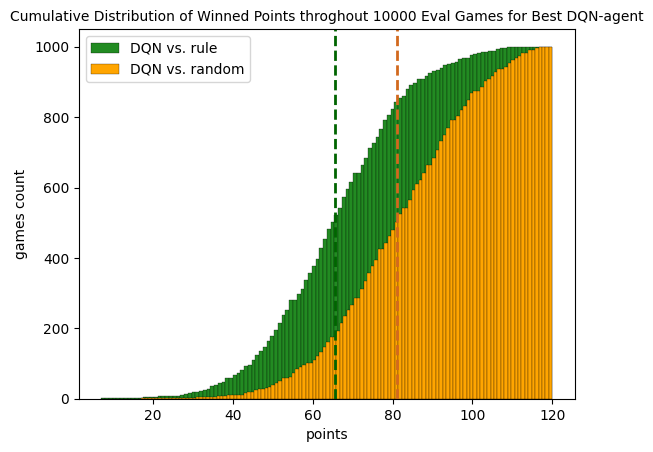

In [17]:
plt.title("Cumulative Distribution of Winned Points throghout 10000 Eval Games for Best DQN-agent", fontsize=10)
plt.xlabel("points")
plt.ylabel("games count")
plt.hist(vs_rule_points, bins=120, color="forestgreen", edgecolor='black', linewidth=0.2, cumulative=True, label="DQN vs. rule")
plt.axvline(np.array(vs_rule_points).mean(), color='darkgreen', linestyle='dashed', linewidth=2)
plt.hist(vs_random_points, bins=120, color="orange", edgecolor='black', linewidth=0.2, cumulative=True, label="DQN vs. random")
plt.axvline(np.array(vs_random_points).mean(), color='chocolate', linestyle='dashed', linewidth=2)
plt.legend()
ax = plt.gca()
plt.savefig('./results/Winned_Points.png', dpi=300)
plt.show()

In [8]:
# Interesting results:

# - 89% winrate vs. agent playing randomly
# - 63% winrate vs. agent playing with rules
# - The agent actually learnt to throw the card that
#   let him win when it has the occasion of reaching 
#   the 61 points threshold
# - 

# Possible improvements:

# - Improve the reward function by considering the 61 points threshold
# - Use some strict rules to play the endgame perfectly
# - Test different architectures
# - Try self-play after first stage of training vs. random and rule agents
# - Do some hyperparameter-tuning
